In [11]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [7]:
#  Folder where your dataset was extracted
data_dir = 'skin_dataset'  # (You already renamed this)

# Image size expected by MobileNetV2
img_size = 224

#  Batch size during training
batch_size = 32

# Number of classes in your dataset
num_classes = 5


In [5]:
data_dir = 'skin_dataset'
print("Classes found:")
for folder in os.listdir(data_dir):
    print("-", folder)


Classes found:
- SJS-TEN
- hyperpigmentation
- Vitiligo
- acne
- Nail_psoriasis


In [8]:

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=25,
    zoom_range=0.3,
    shear_range=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 7640 images belonging to 5 classes.
Found 1908 images belonging to 5 classes.


In [23]:
import json

# Save the class indices from training generator
with open("class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)

# Optional: Print to confirm
print("Class indices saved to class_indices.json")
print(train_gen.class_indices)


Class indices saved to class_indices.json
{'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acne': 3, 'hyperpigmentation': 4}


In [24]:

# Load base model without the top layer
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base layers initially

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [25]:

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [26]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1),
    ModelCheckpoint('derma_model_best.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]


In [27]:

# Extract labels from training generator
labels = train_gen.classes

# Compute balanced weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dictionary format
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)


Class weights: {0: np.float64(0.7579365079365079), 1: np.float64(0.6034755134281201), 2: np.float64(0.9473031618102914), 3: np.float64(1.662676822633297), 4: np.float64(2.7285714285714286)}


In [17]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights
)


/home/deepak/skin_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.3351 - loss: 1.7488
Epoch 1: val_accuracy improved from -inf to 0.71855, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 234s 954ms/step - accuracy: 0.3356 - loss: 1.7475 - val_accuracy: 0.7186 - val_loss: 0.7734 - learning_rate: 1.0000e-04
Epoch 2/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.5947 - loss: 0.9698
Epoch 2: val_accuracy improved from 0.71855 to 0.73637, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 239s 997ms/step - accuracy: 0.5948 - loss: 0.9696 - val_accuracy: 0.7364 - val_loss: 0.6703 - learning_rate: 1.0000e-04
Epoch 3/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.6734 - loss: 0.8002
Epoch 3: val_accuracy improved from 0.73637 to 0.75943, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.6734 - loss: 0.8001 - val_accuracy: 0.7594 - val_loss: 0.6383 - learning_rate: 1.0000e-04
Epoch 4/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7105 - loss: 0.7258
Epoch 4: val_accuracy improved from 0.75943 to 0.78040, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 218s 913ms/step - accuracy: 0.7106 - loss: 0.7256 - val_accuracy: 0.7804 - val_loss: 0.5689 - learning_rate: 1.0000e-04
Epoch 5/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.7486 - loss: 0.6270
Epoch 5: val_accuracy improved from 0.78040 to 0.79350, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 200s 837ms/step - accuracy: 0.7486 - loss: 0.6270 - val_accuracy: 0.7935 - val_loss: 0.5340 - learning_rate: 1.0000e-04
Epoch 6/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.7540 - loss: 0.6123
Epoch 6: val_accuracy improved from 0.79350 to 0.80346, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 205s 859ms/step - accuracy: 0.7540 - loss: 0.6122 - val_accuracy: 0.8035 - val_loss: 0.4972 - learning_rate: 1.0000e-04
Epoch 7/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.7819 - loss: 0.5564
Epoch 7: val_accuracy improved from 0.80346 to 0.82442, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 191s 796ms/step - accuracy: 0.7819 - loss: 0.5564 - val_accuracy: 0.8244 - val_loss: 0.4488 - learning_rate: 1.0000e-04
Epoch 8/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.7883 - loss: 0.5233
Epoch 8: val_accuracy did not improve from 0.82442
239/239 ━━━━━━━━━━━━━━━━━━━━ 176s 735ms/step - accuracy: 0.7884 - loss: 0.5233 - val_accuracy: 0.8213 - val_loss: 0.4674 - learning_rate: 1.0000e-04
Epoch 9/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.7954 - loss: 0.4978
Epoch 9: val_accuracy did not improve from 0.82442
239/239 ━━━━━━━━━━━━━━━━━━━━ 177s 740ms/step - accuracy: 0.7954 - loss: 0.4978 - val_accuracy: 0.8234 - val_loss: 0.4634 - learning_rate: 1.0000e-04
Epoch 10/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.8107 - loss: 0.4643
Epoch 10: val_accuracy did not improve from 0.82442
239/239 ━━━━━━━━━━━━━━━━━━━━ 178s 744ms/step - accuracy: 0.8107 - loss: 0.4643 - val_accuracy: 0.8244 - val_loss: 0.4381 - learning_ra

239/239 ━━━━━━━━━━━━━━━━━━━━ 179s 749ms/step - accuracy: 0.8193 - loss: 0.4535 - val_accuracy: 0.8475 - val_loss: 0.4300 - learning_rate: 1.0000e-04
Epoch 12/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.8275 - loss: 0.4397
Epoch 12: val_accuracy did not improve from 0.84748
239/239 ━━━━━━━━━━━━━━━━━━━━ 195s 813ms/step - accuracy: 0.8275 - loss: 0.4397 - val_accuracy: 0.8422 - val_loss: 0.4382 - learning_rate: 1.0000e-04
Epoch 13/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8217 - loss: 0.4148
Epoch 13: val_accuracy improved from 0.84748 to 0.85168, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 164s 683ms/step - accuracy: 0.8218 - loss: 0.4148 - val_accuracy: 0.8517 - val_loss: 0.4045 - learning_rate: 1.0000e-04
Epoch 14/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8351 - loss: 0.4049
Epoch 14: val_accuracy improved from 0.85168 to 0.86006, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 166s 693ms/step - accuracy: 0.8352 - loss: 0.4049 - val_accuracy: 0.8601 - val_loss: 0.3777 - learning_rate: 1.0000e-04
Epoch 15/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.8422 - loss: 0.3742
Epoch 15: val_accuracy did not improve from 0.86006
239/239 ━━━━━━━━━━━━━━━━━━━━ 144s 604ms/step - accuracy: 0.8422 - loss: 0.3742 - val_accuracy: 0.8595 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 16/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.8463 - loss: 0.3779
Epoch 16: val_accuracy did not improve from 0.86006
239/239 ━━━━━━━━━━━━━━━━━━━━ 155s 649ms/step - accuracy: 0.8463 - loss: 0.3779 - val_accuracy: 0.8548 - val_loss: 0.3854 - learning_rate: 1.0000e-04
Epoch 17/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8496 - loss: 0.3543
Epoch 17: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 17: val_accuracy did not improve from 0.86006
239/239 ━━━━━━━━━━━━━━━━━━━━ 141s 590ms/step - accu

239/239 ━━━━━━━━━━━━━━━━━━━━ 145s 608ms/step - accuracy: 0.8700 - loss: 0.3276 - val_accuracy: 0.8637 - val_loss: 0.3850 - learning_rate: 2.0000e-05
Epoch 21/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8644 - loss: 0.3319
Epoch 21: val_accuracy did not improve from 0.86373
239/239 ━━━━━━━━━━━━━━━━━━━━ 145s 605ms/step - accuracy: 0.8644 - loss: 0.3319 - val_accuracy: 0.8532 - val_loss: 0.3800 - learning_rate: 2.0000e-05
Epoch 22/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8664 - loss: 0.3177
Epoch 22: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 22: val_accuracy did not improve from 0.86373
239/239 ━━━━━━━━━━━━━━━━━━━━ 151s 633ms/step - accuracy: 0.8664 - loss: 0.3177 - val_accuracy: 0.8606 - val_loss: 0.3866 - learning_rate: 2.0000e-05
Epoch 23/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8740 - loss: 0.3066
Epoch 23: val_accuracy did not improve from 0.86373
239/239 ━━━━━━━━━━━━━━━━━━━━ 151s 630ms/step - accur

239/239 ━━━━━━━━━━━━━━━━━━━━ 154s 642ms/step - accuracy: 0.8676 - loss: 0.3163 - val_accuracy: 0.8664 - val_loss: 0.3907 - learning_rate: 4.0000e-06


In [18]:
# Unfreeze the base model
base_model.trainable = True

# Optionally, freeze the very first 100 layers (they capture basic features like edges)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.7208 - loss: 0.7705
Epoch 1: val_accuracy did not improve from 0.86635
239/239 ━━━━━━━━━━━━━━━━━━━━ 215s 841ms/step - accuracy: 0.7209 - loss: 0.7703 - val_accuracy: 0.7568 - val_loss: 0.8591 - learning_rate: 1.0000e-05
Epoch 2/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.7661 - loss: 0.5766
Epoch 2: val_accuracy did not improve from 0.86635
239/239 ━━━━━━━━━━━━━━━━━━━━ 204s 855ms/step - accuracy: 0.7661 - loss: 0.5765 - val_accuracy: 0.7746 - val_loss: 0.8097 - learning_rate: 1.0000e-05
Epoch 3/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7919 - loss: 0.5146
Epoch 3: val_accuracy did not improve from 0.86635
239/239 ━━━━━━━━━━━━━━━━━━━━ 198s 825ms/step - accuracy: 0.7919 - loss: 0.5146 - val_accuracy: 0.8061 - val_loss: 0.6200 - learning_rate: 1.0000e-05
Epoch 4/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8243 - loss: 0.4367
Epoch 4: val_accuracy did not improve from 0.866

239/239 ━━━━━━━━━━━━━━━━━━━━ 226s 946ms/step - accuracy: 0.8609 - loss: 0.3265 - val_accuracy: 0.8684 - val_loss: 0.3673 - learning_rate: 1.0000e-05
Epoch 9/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.8692 - loss: 0.3186
Epoch 9: val_accuracy did not improve from 0.86845
239/239 ━━━━━━━━━━━━━━━━━━━━ 201s 841ms/step - accuracy: 0.8692 - loss: 0.3186 - val_accuracy: 0.8512 - val_loss: 0.4567 - learning_rate: 1.0000e-05
Epoch 10/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.8777 - loss: 0.2851
Epoch 10: val_accuracy did not improve from 0.86845
239/239 ━━━━━━━━━━━━━━━━━━━━ 209s 872ms/step - accuracy: 0.8777 - loss: 0.2851 - val_accuracy: 0.8611 - val_loss: 0.4156 - learning_rate: 1.0000e-05
Epoch 11/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8952 - loss: 0.2548
Epoch 11: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 11: val_accuracy did not improve from 0.86845
239/239 ━━━━━━━━━━━━━━━━━━━━ 218s 913ms/step - accura

239/239 ━━━━━━━━━━━━━━━━━━━━ 193s 809ms/step - accuracy: 0.8956 - loss: 0.2618 - val_accuracy: 0.8721 - val_loss: 0.4085 - learning_rate: 2.0000e-06
Epoch 13/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.8989 - loss: 0.2531
Epoch 13: val_accuracy improved from 0.87212 to 0.87683, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 211s 882ms/step - accuracy: 0.8989 - loss: 0.2531 - val_accuracy: 0.8768 - val_loss: 0.3606 - learning_rate: 2.0000e-06
Epoch 14/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.8930 - loss: 0.2389
Epoch 14: val_accuracy improved from 0.87683 to 0.87998, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 216s 904ms/step - accuracy: 0.8930 - loss: 0.2389 - val_accuracy: 0.8800 - val_loss: 0.3460 - learning_rate: 2.0000e-06
Epoch 15/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.9034 - loss: 0.2345
Epoch 15: val_accuracy improved from 0.87998 to 0.88522, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 212s 886ms/step - accuracy: 0.9034 - loss: 0.2345 - val_accuracy: 0.8852 - val_loss: 0.3457 - learning_rate: 2.0000e-06
Epoch 16/25
146/239 ━━━━━━━━━━━━━━━━━━━━ 1:12 783ms/step - accuracy: 0.8959 - loss: 0.2334

In [30]:
from tensorflow.keras.models import load_model
model = load_model("derma_model_best.h5")


In [31]:

model.compile(
    optimizer=Adam(learning_rate=2e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [32]:
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    initial_epoch=15,
    callbacks=callbacks,
    class_weight=class_weights
)





Epoch 16/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9141 - loss: 0.2262
Epoch 16: val_accuracy improved from -inf to 0.87317, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - accuracy: 0.9141 - loss: 0.2262 - val_accuracy: 0.8732 - val_loss: 0.3920 - learning_rate: 2.0000e-06
Epoch 17/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9051 - loss: 0.2286
Epoch 17: val_accuracy improved from 0.87317 to 0.88679, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.9051 - loss: 0.2286 - val_accuracy: 0.8868 - val_loss: 0.3629 - learning_rate: 2.0000e-06
Epoch 18/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9091 - loss: 0.2214
Epoch 18: val_accuracy did not improve from 0.88679
239/239 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.9091 - loss: 0.2214 - val_accuracy: 0.8768 - val_loss: 0.3712 - learning_rate: 2.0000e-06
Epoch 19/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9087 - loss: 0.2117
Epoch 19: val_accuracy improved from 0.88679 to 0.88836, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9087 - loss: 0.2117 - val_accuracy: 0.8884 - val_loss: 0.3474 - learning_rate: 2.0000e-06
Epoch 20/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9106 - loss: 0.2156
Epoch 20: val_accuracy did not improve from 0.88836
239/239 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9106 - loss: 0.2156 - val_accuracy: 0.8884 - val_loss: 0.3470 - learning_rate: 2.0000e-06
Epoch 21/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9154 - loss: 0.2001
Epoch 21: val_accuracy improved from 0.88836 to 0.89413, saving model to derma_model_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9153 - loss: 0.2001 - val_accuracy: 0.8941 - val_loss: 0.3375 - learning_rate: 2.0000e-06
Epoch 22/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9176 - loss: 0.2036
Epoch 22: val_accuracy did not improve from 0.89413
239/239 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9176 - loss: 0.2036 - val_accuracy: 0.8857 - val_loss: 0.3306 - learning_rate: 2.0000e-06
Epoch 23/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9108 - loss: 0.2169
Epoch 23: val_accuracy did not improve from 0.89413
239/239 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.9108 - loss: 0.2169 - val_accuracy: 0.8910 - val_loss: 0.3352 - learning_rate: 2.0000e-06
Epoch 24/25
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9191 - loss: 0.2059
Epoch 24: val_accuracy did not improve from 0.89413
239/239 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.9190 - loss: 0.2059 - val_accuracy: 0.8810 - val_loss: 0.3639 - learning_rate: 2.0000e-06
Ep

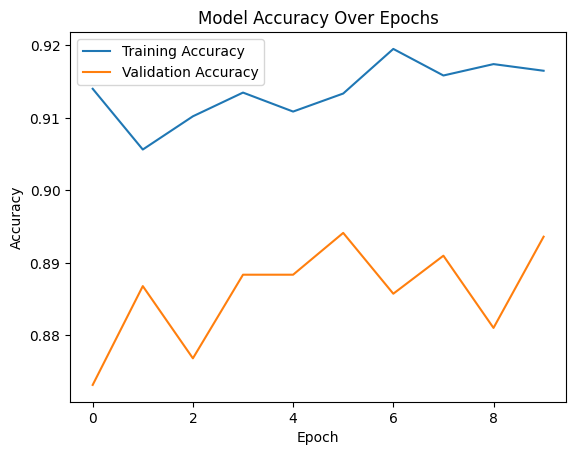

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:

model = load_model("derma_model_best.h5")


2025-07-15 06:05:02.206190: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
import json

with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

# Reverse mapping: index to class name
idx_to_class = {v: k for k, v in class_indices.items()}


In [88]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "Crop-0350_100400vitiligo5__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDIyXQ.jpg"  # Change this to your image name

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize like training data
img_array = np.expand_dims(img_array, axis=0)


In [89]:
pred = model.predict(img_array)
predicted_class_index = np.argmax(pred)
predicted_class_name = idx_to_class[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted class: Vitiligo


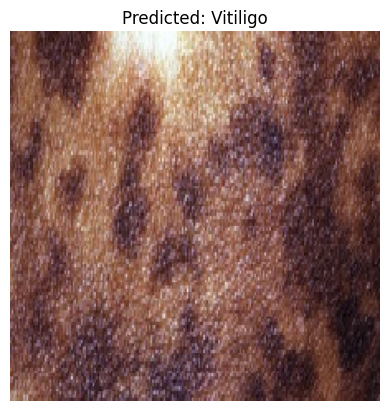

In [90]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()
